In [1]:
"""
A. For each tissue, enrichment [how likely are eSTRs to fall in TF sites]
Fisher test at each tissue
    Background: All STRs
    Forground: eSTRs that fall within TFs 

"""

# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

#variables

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}
TISSUES = sorted([item for item in list(SHORTEN.keys())])
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'


In [ ]:
#open files
#regression summary


#Select eSTRs only
TFs = '/storage/mgymrek/gtex/tfbs/encodedata/'
transfacts = os.listdir(TFs)
transfacts = [x for x in transfacts if x!='sorted']

#intersect + Cont. table + Fisher test
pdata = np.zeros((len(TISSUES), len(transfacts)))
DATA=defaultdict(list)

for i in range (len(TISSUES)):
    # Data
    P=[]
    tis = TISSUES[i]
    data = pd.read_csv(regr+tis+'/Master.table', sep='\t')
    print(data.shape)
    #estrs in tissue
    data_e =data.loc[data['qvalue']>0.1]      
    
    #TFs in tissue
    for j in range (len(transfacts)):
        item = transfacts[j]
        try:
            TF = pd.read_csv(TFs+item, sep='\t', header=None)
            TF.columns = ['chrom','start','stop','strand','numb1','num2','numb3', 'numb4','num5','numb6']
        except:
            print(TFs+item, ' has no data')
            pdata[i][j]='NA'
            continue
    
        #intersect
        data[['chrom','str.start','str.end','gene','str.id']].to_csv('reg.bed', sep='\t',index=None, header=None)
        fact = TF[['chrom','start','stop']]; fact.to_csv('facts.bed', sep='\t',index=None, header=None)
        cmd = "bedtools intersect -a reg.bed -b facts.bed -wa >Intersect.bed"
        returned_value = os.system(cmd)
        try:
            inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
            TFS = inner.shape[0]
        except:
            #print(item, ' has no overlap')
            TFS = 0
        
        data_e[['chrom','str.start','str.end','gene','str.id']].to_csv('reg.bed', sep='\t',index=None, header=None)
        cmd = "bedtools intersect -a reg.bed -b facts.bed -wb -names Gene >Intersect.bed"
        returned_value = os.system(cmd)
        try:
            inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
            TFE = inner.shape[0]
        except:
            #print(item, ' has no overlap in eSTRs')
            TFE = 0
 
        #Cont Table
        nTFE = data_e.shape[0] - TFE
        nTFS = data.shape[0] - data_e.shape[0] - TFS
        
        CTT = [[TFE , TFS - TFE] , [data_e.shape[0] - TFE , data.shape[0]- data_e.shape[0] - (TFS - TFE)]]
        #Fishar
        oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])
        P.append(pv)
        pdata[i][j] = -np.log10(pv)
    DATA[SHORTEN[tis]]=P
    print(tis, len(DATA[SHORTEN[tis]]))


df = pd.DataFrame(pdata)
df.columns = A
df.index = [SHORTEN[x] for x in TISSUES]

df.to_csv('enrichment', sep='\t', index=None)

(11944, 22)


In [ ]:
danbindtrnscfact = pd.read_csv()

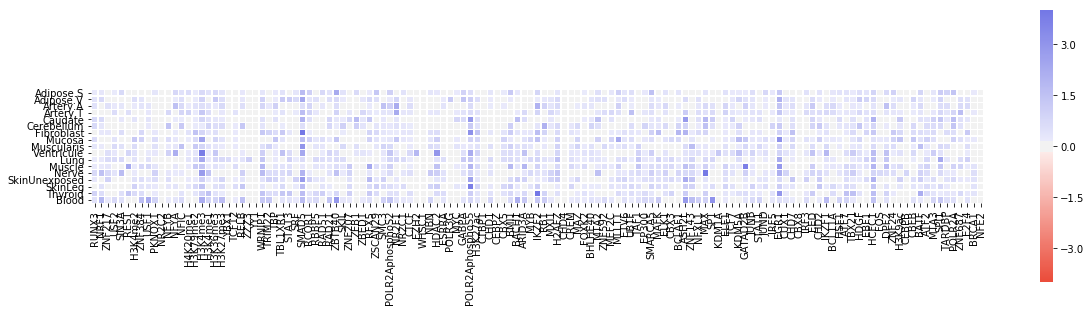

In [4]:
df = pd.read_csv('enrichment', sep='\t')
A = [x.split('.')[0] for x in list(df.columns)]
Null = [x for x in df.columns if sum(df[x])==0]

GM = [s for s in A if 'GM12878' in s]
pdataf = df[GM]    
fig, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdataf, cmap=cmap,  annot_kws={"size": 5},
            vmin=-4, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=[x.split('_')[0] for x in list(pdataf.columns)]);
ax.invert_xaxis();
plt.show()

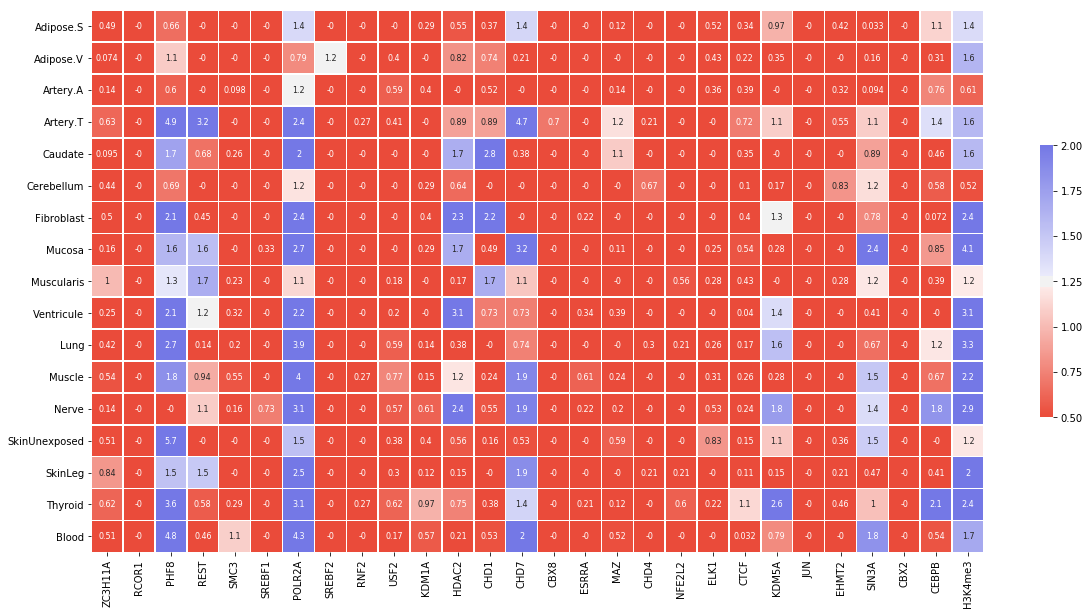

In [46]:
A5 = [s for s in A if 'A549' in s]
pdataf = df[A5]    
fig, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdataf, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=[x.split('_')[0] for x in list(pdataf.columns)]);
ax.invert_xaxis();
plt.show()


In [ ]:
Cell lines
        GM12878    
        A549       
        OCI-LY7    
        HL-60        
        NB4      

In [ ]:
Newdf = pd.DataFrame(DATA)
Newdf.index = transfacts
Newdf['total'] = Newdf.sum(axis=1)
print(Newdf.shape)
Newdf1 = Newdf.loc[Newdf['total']!=17]
print(Newdf1.shape)
test = np.log10(Newdf1)
fig, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(test, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=[SHORTEN[t] for t in TISSUES], 
           yticklabels=[x.split('_')[0] for x in list(test.columns)]);
#ax.invert_xaxis();
plt.show()

In [57]:
Null = [x for x in df.columns if sum(df[x])==0]
Null

['NFE2_GM12878',
 'CBX2_A549',
 'CBX8_GM12878',
 'JUN_A549',
 'CHD4_GM12878',
 'CEBPZ_GM12878',
 'CTBP1_GM12878',
 'WHSC1_GM12878',
 'YY1_GM12878',
 'H3K9me2_OCI-LY7',
 'NR2C2_GM12878',
 'RCOR1_A549']

In [ ]:
Null = [x for x in df.columns if sum(df[x])==0]
Null